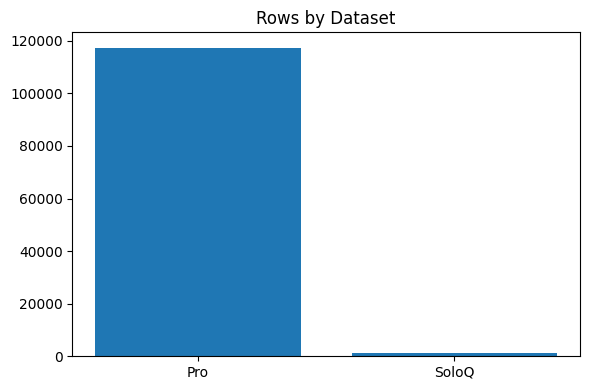

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sq = pd.read_csv("./SoloQ/data/soloq_full_15.24.csv", low_memory=False)
pr = pd.read_csv("./pro/data/pro_2025_cleaned.csv", low_memory=False)

def pick_col(d, names):
    for n in names:
        if n in d.columns: return n
    return None

sq['dataset'] = 'SoloQ'
pr['dataset'] = 'Pro'

sq_k = pick_col(sq, ['kills'])
sq_d = pick_col(sq, ['deaths'])
sq_a = pick_col(sq, ['assists'])
sq_gp = pick_col(sq, ['gpm','goldPerMinute','ch_goldPerMinute','challenges_goldPerMinute'])
sq_dp = pick_col(sq, ['dpm','damagePerMinute','ch_damagePerMinute','challenges_damagePerMinute'])
sq_cs = pick_col(sq, ['cspm'])
sq_tp = pick_col(sq, ['timePlayed','gameDuration'])
sq_vs = pick_col(sq, ['visionScore'])
sq_wp = pick_col(sq, ['wardsPlaced'])
sq_pos = pick_col(sq, ['teamPosition','individualPosition','role','lane'])
sq_champ = pick_col(sq, ['championName'])
sq_dmgshare = pick_col(sq, ['ch_teamDamagePercentage','challenges_teamDamagePercentage'])

pr_k = pick_col(pr, ['kills','k'])
pr_d = pick_col(pr, ['deaths','d'])
pr_a = pick_col(pr, ['assists','a'])
pr_gp = pick_col(pr, ['gpm','gold_per_minute','goldperminute'])
pr_dp = pick_col(pr, ['dpm','dmg_per_minute','damage_per_minute'])
pr_cs = pick_col(pr, ['cspm','cs_per_minute','csmin'])
pr_tp = pick_col(pr, ['timePlayed','game_time_s','game_time','gameduration','duration'])
pr_vs = pick_col(pr, ['visionScore','vision_score'])
pr_wp = pick_col(pr, ['wardsPlaced','wards_placed'])
pr_pos = pick_col(pr, ['position','pos','role','lane'])
pr_champ = pick_col(pr, ['champion','championname','champ'])
pr_dmgshare = pick_col(pr, ['teamDamagePercentage','team_damage_pct','team_dmg_share'])

def to_minutes(s):
    if s is None: return np.nan
    v = s.astype(float)
    if v.max() and v.max()>2000: return v/60.0
    return v

sq_df = pd.DataFrame({
    'dataset': sq['dataset'],
    'kills': sq[sq_k] if sq_k else np.nan,
    'deaths': sq[sq_d] if sq_d else np.nan,
    'assists': sq[sq_a] if sq_a else np.nan,
    'gpm': sq[sq_gp] if sq_gp else np.nan,
    'dpm': sq[sq_dp] if sq_dp else np.nan,
    'cspm': sq[sq_cs] if sq_cs else np.nan,
    'minutes': to_minutes(sq[sq_tp]) if sq_tp else np.nan,
    'visionScore': sq[sq_vs] if sq_vs else np.nan,
    'wardsPlaced': sq[sq_wp] if sq_wp else np.nan,
    'position': sq[sq_pos].astype(str).str.upper() if sq_pos else 'UNKNOWN',
    'champion': sq[sq_champ] if sq_champ else 'UNKNOWN',
    'teamDmgPct': (sq[sq_dmgshare]*100.0) if sq_dmgshare else np.nan
})

pr_df = pd.DataFrame({
    'dataset': pr['dataset'],
    'kills': pr[pr_k] if pr_k else np.nan,
    'deaths': pr[pr_d] if pr_d else np.nan,
    'assists': pr[pr_a] if pr_a else np.nan,
    'gpm': pr[pr_gp] if pr_gp else np.nan,
    'dpm': pr[pr_dp] if pr_dp else np.nan,
    'cspm': pr[pr_cs] if pr_cs else np.nan,
    'minutes': to_minutes(pr[pr_tp]) if pr_tp else np.nan,
    'visionScore': pr[pr_vs] if pr_vs else np.nan,
    'wardsPlaced': pr[pr_wp] if pr_wp else np.nan,
    'position': pr[pr_pos].astype(str).str.upper() if pr_pos else 'UNKNOWN',
    'champion': pr[pr_champ] if pr_champ else 'UNKNOWN',
    'teamDmgPct': (pr[pr_dmgshare]*100.0) if pr_dmgshare else np.nan
})

df = pd.concat([sq_df, pr_df], ignore_index=True)
safe_deaths = df['deaths'].replace(0, np.nan)
df['kda_robust'] = (df['kills'] + df['assists']) / safe_deaths
df['kda_robust'] = df['kda_robust'].replace([np.inf,-np.inf], np.nan).fillna(df['kills']+df['assists'])
df['vpm'] = df['visionScore'] / (df['minutes'].replace(0, np.nan))
pos_map = {'MIDDLE':'MID','MID':'MID','BOTTOM':'ADC','ADC':'ADC','CARRY':'ADC','UTILITY':'SUPPORT','SUPPORT':'SUPPORT','JUNGLE':'JUNGLE','TOP':'TOP'}
df['pos_norm'] = df['position'].map(pos_map).fillna(df['position'])
order_pos = ['TOP','JUNGLE','MID','ADC','SUPPORT']
df['pos_norm'] = pd.Categorical(df['pos_norm'], categories=order_pos, ordered=True)

plt.figure(figsize=(6,4))
counts = df['dataset'].value_counts().sort_index()
plt.bar(counts.index, counts.values)
plt.title("Rows by Dataset")
plt.tight_layout()


C:\Users\JH\AppData\Local\Temp\ipykernel_14936\1476318369.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, labels=['SoloQ','Pro'], showfliers=False)


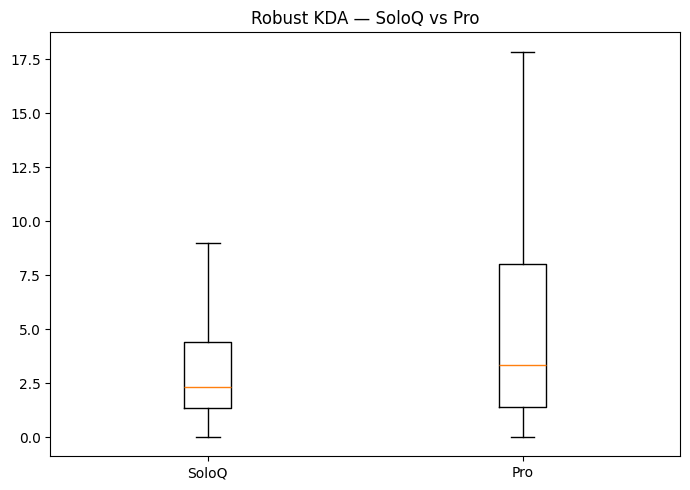

In [2]:
subset = df[['dataset','kda_robust']].dropna()
vals = [subset.loc[subset['dataset']=='SoloQ','kda_robust'].values,
        subset.loc[subset['dataset']=='Pro','kda_robust'].values]
plt.figure(figsize=(7,5))
plt.boxplot(vals, labels=['SoloQ','Pro'], showfliers=False)
plt.title("Robust KDA — SoloQ vs Pro")
plt.tight_layout()


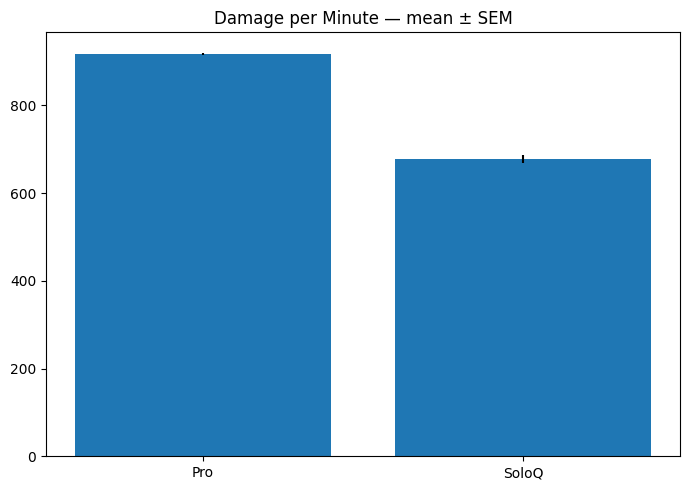

In [4]:
metric = 'dpm'
sub = df[['dataset',metric]].dropna()
m = sub.groupby('dataset')[metric].agg(['mean','std','count'])
x = np.arange(len(m.index))
plt.figure(figsize=(7,5))
plt.bar(x, m['mean'].values, yerr=(m['std']/np.sqrt(m['count'])).values)
plt.xticks(x, m.index)
plt.title("Damage per Minute — mean ± SEM")
plt.tight_layout()


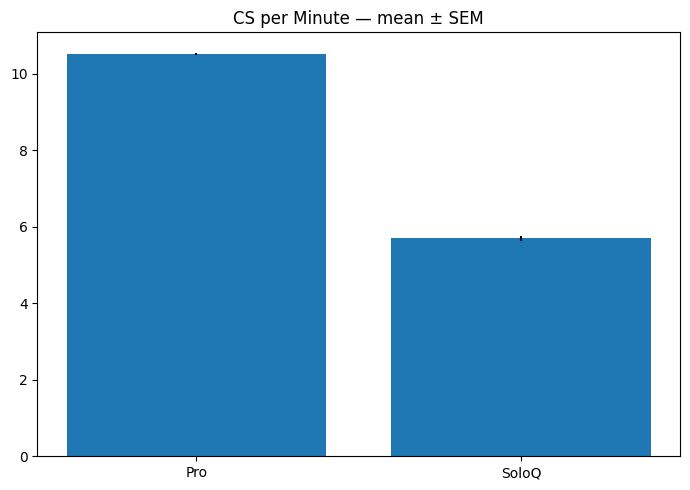

In [5]:
metric = 'cspm'
sub = df[['dataset',metric]].dropna()
m = sub.groupby('dataset')[metric].agg(['mean','std','count'])
x = np.arange(len(m.index))
plt.figure(figsize=(7,5))
plt.bar(x, m['mean'].values, yerr=(m['std']/np.sqrt(m['count'])).values)
plt.xticks(x, m.index)
plt.title("CS per Minute — mean ± SEM")
plt.tight_layout()


C:\Users\JH\AppData\Local\Temp\ipykernel_14936\2843657672.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (df.groupby(['dataset','pos_norm'])['champion'].nunique()


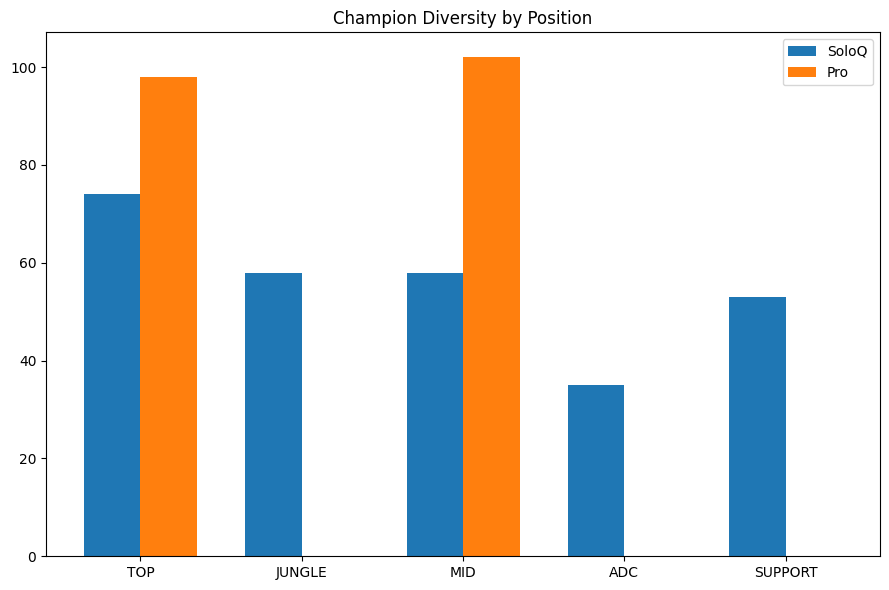

In [8]:
tab = (df.groupby(['dataset','pos_norm'])['champion'].nunique()
         .rename('unique_champs')
         .reset_index())
pivot = tab.pivot(index='pos_norm', columns='dataset', values='unique_champs').loc[order_pos]
pivot = pivot.fillna(0)
x = np.arange(len(pivot.index))
w = 0.35
plt.figure(figsize=(9,6))
plt.bar(x-w/2, pivot['SoloQ'], width=w, label='SoloQ')
plt.bar(x+w/2, pivot['Pro'],   width=w, label='Pro')
plt.xticks(x, pivot.index.astype(str), rotation=0)
plt.title("Champion Diversity by Position")
plt.legend()
plt.tight_layout()


C:\Users\JH\AppData\Local\Temp\ipykernel_14936\2843657672.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  tab = (df.groupby(['dataset','pos_norm'])['champion'].nunique()


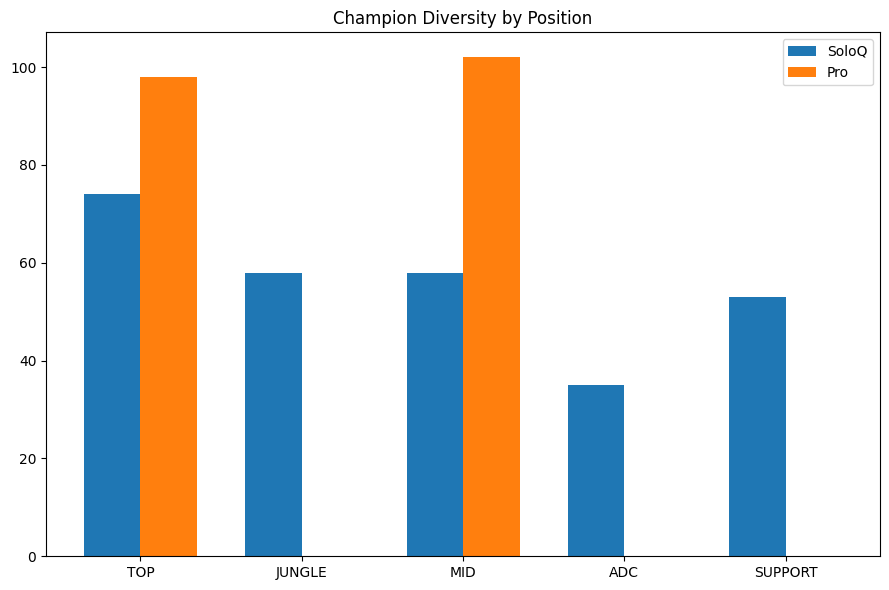

In [9]:
tab = (df.groupby(['dataset','pos_norm'])['champion'].nunique()
         .rename('unique_champs')
         .reset_index())
pivot = tab.pivot(index='pos_norm', columns='dataset', values='unique_champs').loc[order_pos]
pivot = pivot.fillna(0)
x = np.arange(len(pivot.index))
w = 0.35
plt.figure(figsize=(9,6))
plt.bar(x-w/2, pivot['SoloQ'], width=w, label='SoloQ')
plt.bar(x+w/2, pivot['Pro'],   width=w, label='Pro')
plt.xticks(x, pivot.index.astype(str), rotation=0)
plt.title("Champion Diversity by Position")
plt.legend()
plt.tight_layout()


C:\Users\JH\AppData\Local\Temp\ipykernel_14936\2187738697.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  counts = (df.groupby(['dataset','pos_norm'])['champion'].count()


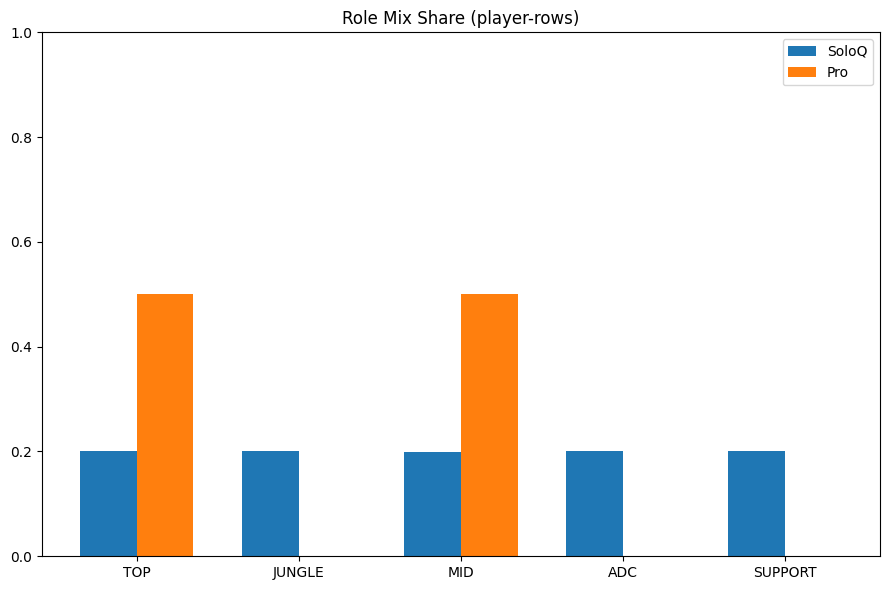

In [10]:
counts = (df.groupby(['dataset','pos_norm'])['champion'].count()
            .rename('rows').reset_index())
p = counts.pivot(index='pos_norm', columns='dataset', values='rows').loc[order_pos].fillna(0)
tot = p.sum(axis=0)
share = p.div(tot, axis=1)
x = np.arange(len(share.index))
w = 0.35
plt.figure(figsize=(9,6))
plt.bar(x-w/2, share['SoloQ'].values, width=w, label='SoloQ')
plt.bar(x+w/2, share['Pro'].values,   width=w, label='Pro')
plt.xticks(x, share.index.astype(str))
plt.ylim(0,1)
plt.title("Role Mix Share (player-rows)")
plt.legend()
plt.tight_layout()


C:\Users\JH\AppData\Local\Temp\ipykernel_14936\580969035.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = (sub.groupby(['dataset','pos_norm'])['cspm']


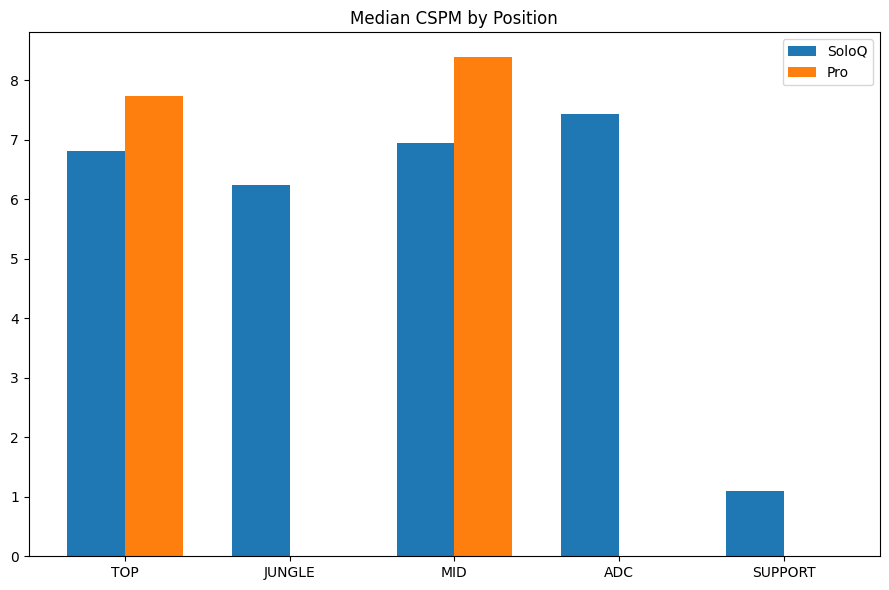

In [11]:
sub = df[['dataset','pos_norm','cspm']].dropna()
g = (sub.groupby(['dataset','pos_norm'])['cspm']
        .median().rename('median_cspm').reset_index())
g = g.pivot(index='pos_norm', columns='dataset', values='median_cspm').loc[order_pos].fillna(0)
x = np.arange(len(g.index))
w = 0.35
plt.figure(figsize=(9,6))
plt.bar(x-w/2, g['SoloQ'], width=w, label='SoloQ')
plt.bar(x+w/2, g['Pro'],   width=w, label='Pro')
plt.xticks(x, g.index.astype(str))
plt.title("Median CSPM by Position")
plt.legend()
plt.tight_layout()


In [21]:
pr['dpm']

0          759.6482
1          187.0477
2          525.8291
3          259.9749
4          157.3116
            ...    
117343     841.7317
117344     832.0543
117345     173.0730
117346    2985.9423
117347    2547.6061
Name: dpm, Length: 117348, dtype: float64

In [37]:
def pick(d, names):
    for n in names:
        if n in d.columns: return n

sq['tier'] = sq['tier'].astype(str).str.strip().str.upper()
order = ["IRON","BRONZE","SILVER","GOLD","PLATINUM","EMERALD","DIAMOND","MASTER","GRANDMASTER","CHALLENGER"]
sq['tier'] = pd.Categorical(sq['tier'], categories=order, ordered=True)

sq_dpm = pick(sq, ['dpm','damagePerMinute','ch_damagePerMinute','challenges_damagePerMinute'])
sq_cspm = pick(sq, ['cspm'])
pr_dpm = pick(pr, ['dpm','dmg_per_minute','damage_per_minute'])
pr_cspm = pick(pr, ['cspm','cs_per_minute','csmin'])

sq_dpm_agg = sq.groupby('tier')[sq_dpm].mean().dropna().reset_index() if sq_dpm else None
sq_cspm_agg = sq.groupby('tier')[sq_cspm].mean().dropna().reset_index() if sq_cspm else None
pro_dpm_mean = pr[pr_dpm].mean() if pr_dpm else np.nan
pro_cspm_mean = pr[pr_cspm].mean() if pr_cspm else np.nan

sq_dpm_agg.loc[len(sq_dpm_agg)] = ['PRO', pro_dpm_mean]
sq_cspm_agg.loc[len(sq_cspm_agg)] = ['PRO', pro_cspm_mean]
sq_dpm_agg['tier'] = pd.Categorical(sq_dpm_agg['tier'], categories=order+['PRO'], ordered=True)
sq_cspm_agg['tier'] = pd.Categorical(sq_cspm_agg['tier'], categories=order+['PRO'], ordered=True)
sq_dpm_agg = sq_dpm_agg.sort_values('tier')
sq_cspm_agg = sq_cspm_agg.sort_values('tier')

C:\Users\JH\AppData\Local\Temp\ipykernel_14936\2867514972.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sq_dpm_agg = sq.groupby('tier')[sq_dpm].mean().dropna().reset_index() if sq_dpm else None
C:\Users\JH\AppData\Local\Temp\ipykernel_14936\2867514972.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sq_cspm_agg = sq.groupby('tier')[sq_cspm].mean().dropna().reset_index() if sq_cspm else None


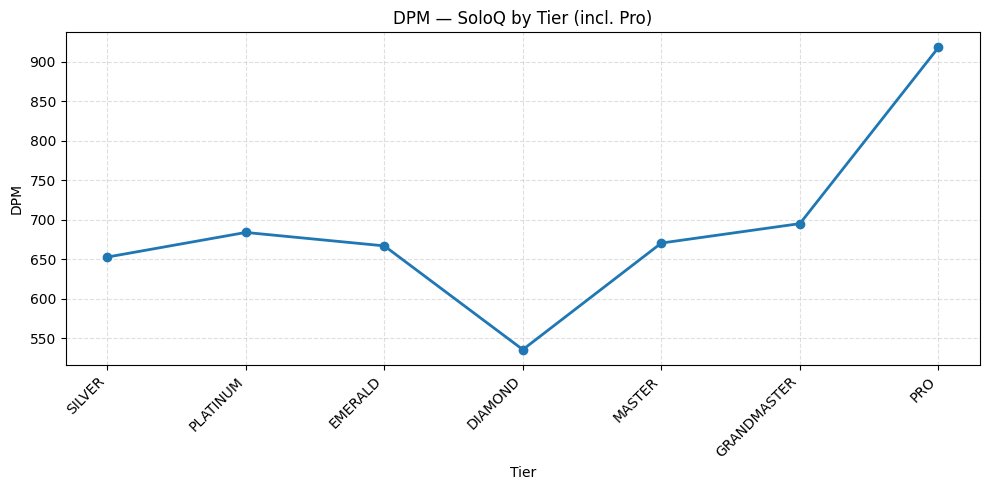

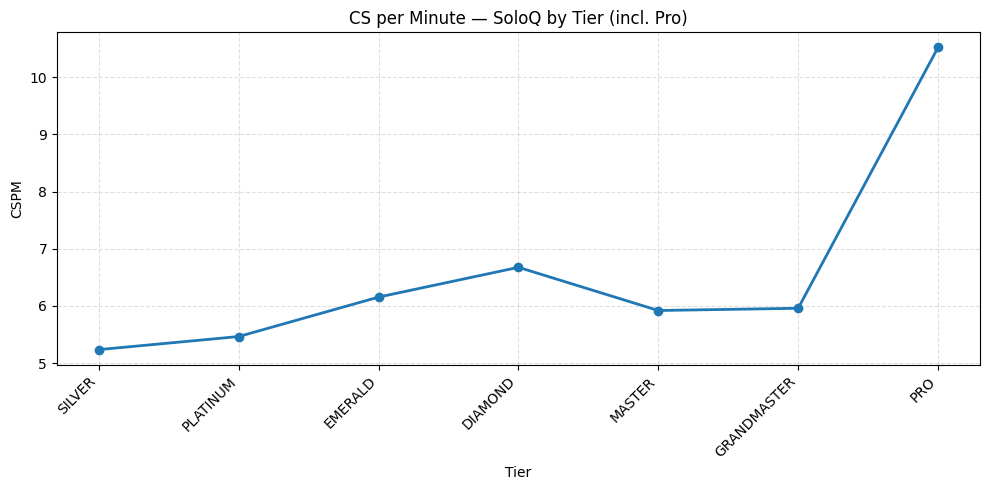

In [38]:
plt.figure(figsize=(10,5))
plt.plot(sq_dpm_agg['tier'].astype(str), sq_dpm_agg[sq_dpm], marker='o', linewidth=2)
plt.title("DPM — SoloQ by Tier (incl. Pro)")
plt.xlabel("Tier")
plt.ylabel("DPM")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()

plt.figure(figsize=(10,5))
plt.plot(sq_cspm_agg['tier'].astype(str), sq_cspm_agg[sq_cspm], marker='o', linewidth=2)
plt.title("CS per Minute — SoloQ by Tier (incl. Pro)")
plt.xlabel("Tier")
plt.ylabel("CSPM")
plt.xticks(rotation=45, ha='right')
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()